<a href="https://colab.research.google.com/github/OrganicSpector/dbproject/blob/master/(HW6)Shor_s_Algorithm_for_factoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shor's Algorithm for factoring

In this tutorial, we will walk through Shor’s Algorithm using the quantum circuit model.   
As we know already, the security of RSA is based on the use of a one-way function – prime factorization – which is related to the problem of period ﬁnding in modular exponentiation. As we saw, if one picks two prime numbers, $p$ and $q$, which multiply together to give a modulus $N$, then one can efﬁciently ﬁnd the modular exponentiation period $r$, and thus generate a public encryption key e and a private decryption key $d$. However, if we are just given the modulus $N$, then we are stuck, because there’s no known efﬁcient classical algorithm that lets us ﬁnd the prime factors $p$ and $q$, and so there’s no efﬁcient means to determine the period $r$. Thus, even if we reveal the modulus $N$ and the public encryption key $e$, there is no known efﬁcient way for an eavesdropper to calculate the private key $d$ on a classical computer. However, **if Eve has access to a quantum computer** that can run Shor’s Algorithm, then she can efﬁciently ﬁnd the modular exponentiation period r.  

$$e\cdot d = 1 \mod r ~~~~~\rightarrow~~~~~ d = e^{−1} \mod r$$  

This is called order ﬁnding, and Shor’s Algorithm ﬁnds the order $r$ of a number $a$ with respect to the modulus $N$,    

$$a^x \mod N ~~~~~\rightarrow~~~~~ \text{order (period) } r,$$  

where $a$ is the number that is raised to integer powers under modular exponentiation. With a means to efﬁciently determine $r$, Eve can calculate the prime numbers $p$ and $q$ and then derive the decryption key $d$, thus compromising RSA.

Let’s walk through Shor's algorithm, step by step, with the initialization stage. We need two registers of qubits for Shor’s Algorithm. Register 1 is used to store the results of a period ﬁnding protocol, which is implemented using the Quantum Fourier Transform. Register 2 is used to store the values of the modular exponentiation. This is the function that will apply in the compute section. The number of qubits in the ﬁrst register should generate a state space that is at least large enough to capture the maximum possible period, and do so at least twice to see it repeat. Let’s deﬁne N as twice the maximum period. So we need  

$$2 L > 2r_{max} = N ~~~~~\rightarrow~~~~~ N^2 < 2^{2L} < 2N^2  ~~~~~\rightarrow~~~~~  2L \text{ qubits}.$$

The more qubits we have, the more densely we can sample the solution space, and thereby reduce the error in determining the period. Here, we’ll take 2L qubits for the ﬁrst register. And for simplicity, we’ll use the same number of qubits in the second register. By choosing 2L qubits, the number of states – $2^{2L} > N^2$. This guarantees that there are at least $N$ terms contributing to the probability amplitude when estimating the period, even as the period $r$ gets exponentially large, approaching $N/2$.  

We prepare the qubits in state $|0\rangle^{\otimes 2L}$.

Next, at the compute stage, we use Hadamard gates to place the register 1 qubits into an equal superposition state. We again use the superscripted tensor product notation to indicate that we apply a Hadamard gate to each of the $2L$ qubits. This puts each qubit into a superposition state, $\frac{1}{\sqrt{2}}(| 0 \rangle + | 1\rangle)$. Multiplying out all $2L$ of these single qubit superposition states results in a single large equal superposition state with $2^{2L}$ components. From a component with $2L$ qubits in state $| 0 \rangle$ to a component with all qubits in state $| 1 \rangle$, and with all combinations in between. If we now number these components from $0$ to $2^{2L−1}$, we can rewrite the superposition state as a sum over $x$   

$$
|0\rangle^{\otimes 2L}|0\rangle^{\otimes 2L} \nonumber \xrightarrow {\substack{H^{\otimes 2L}}}\frac{1}{\sqrt{2^{2L}}} \Big(|0\rangle + |1\rangle\Big)^{\otimes 2L} |0\rangle^{\otimes 2L}  =  \frac{1}{\sqrt{2^{2L}}}\Big(|00\cdots 0\rangle + \cdots + |11\cdots 1\rangle\Big)|0\rangle^{\otimes 2L}   = \frac{1}{\sqrt{2^{2L}}}\sum_{x=0}^{2^{2L}-1}|x\rangle|0\rangle^{\otimes 2L}.
$$

In fact, each decimal number $x$ corresponds to one of the binary numbers represented by the $2L$ qubits. Next, the function $f(x) = a^x \mod N$ is performed:  

$$
\frac{1}{\sqrt{2^{2L}}}\sum_{x=0}^{2^{2L}-1}|x\rangle|0\rangle^{\otimes 2L} \xrightarrow {\substack{U_{f(x)}}} \frac{1}{\sqrt{2^{2L}}}\sum_{x=0}^{2^{2L}-1}|x\rangle|f(x)\rangle =  \frac{1}{\sqrt{2^{2L}}}\sum_{x=0}^{2^{2L}-1}|x\rangle|a^x \mod N\rangle.
$$  

$f(x)$ implements modular exponentiation, which outputs a number $a^x \mod N$. We will present in detail how the modular exponentiation is implemented in a real circuit below. In fact, there are multiple approaches to doing it based on reversible computing and multiplication algorithms. The approach we adopt is based on [this article](https://arxiv.org/pdf/quant-ph/0205095.pdf). We note that this function is implemented using ancilla qubits and it’s efﬁcient, requiring a number of gates that scales only polynomially with the number of qubits.  
The number $a$ is chosen at random, and it must be co-prime with $N$. That is, it must have no common factors with $N$. The resulting output values from the function $f$ are then stored in the Register 2 qubits. Since the values of the power $x$ are taken from the qubits in the ﬁrst register, implementing $f(x)$ makes a conditional connection between the qubits in Register 1 and those in Register 2. Although we ultimately won’t need to measure the qubits in Register 2, this step sets the stage for quantum interference and quantum parallelism to occur in Register 1 at the next step, which is the Quantum Fourier Transform. Here is how the circuit looks like. Below we will implement each building block of the circuit.


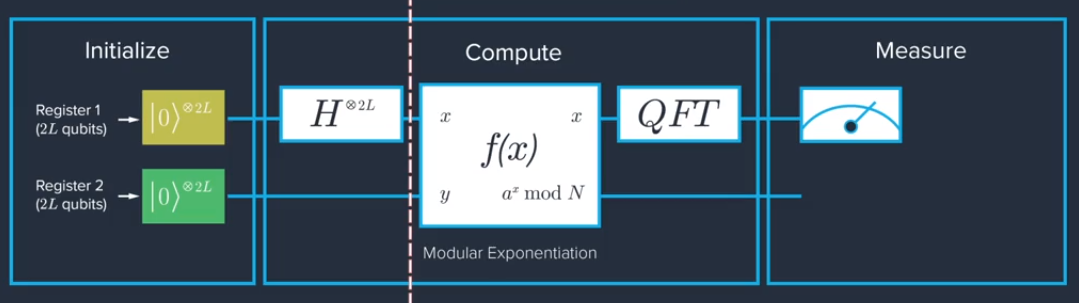

## Implementation of the Modular Exponentiation

We will adopt the approach presented in [this article](https://arxiv.org/pdf/quant-ph/0205095.pdf) which uses Kitaev's version of order finding in Shor's algorithm, **Phase Estimation Algorithm** as a subroutine.
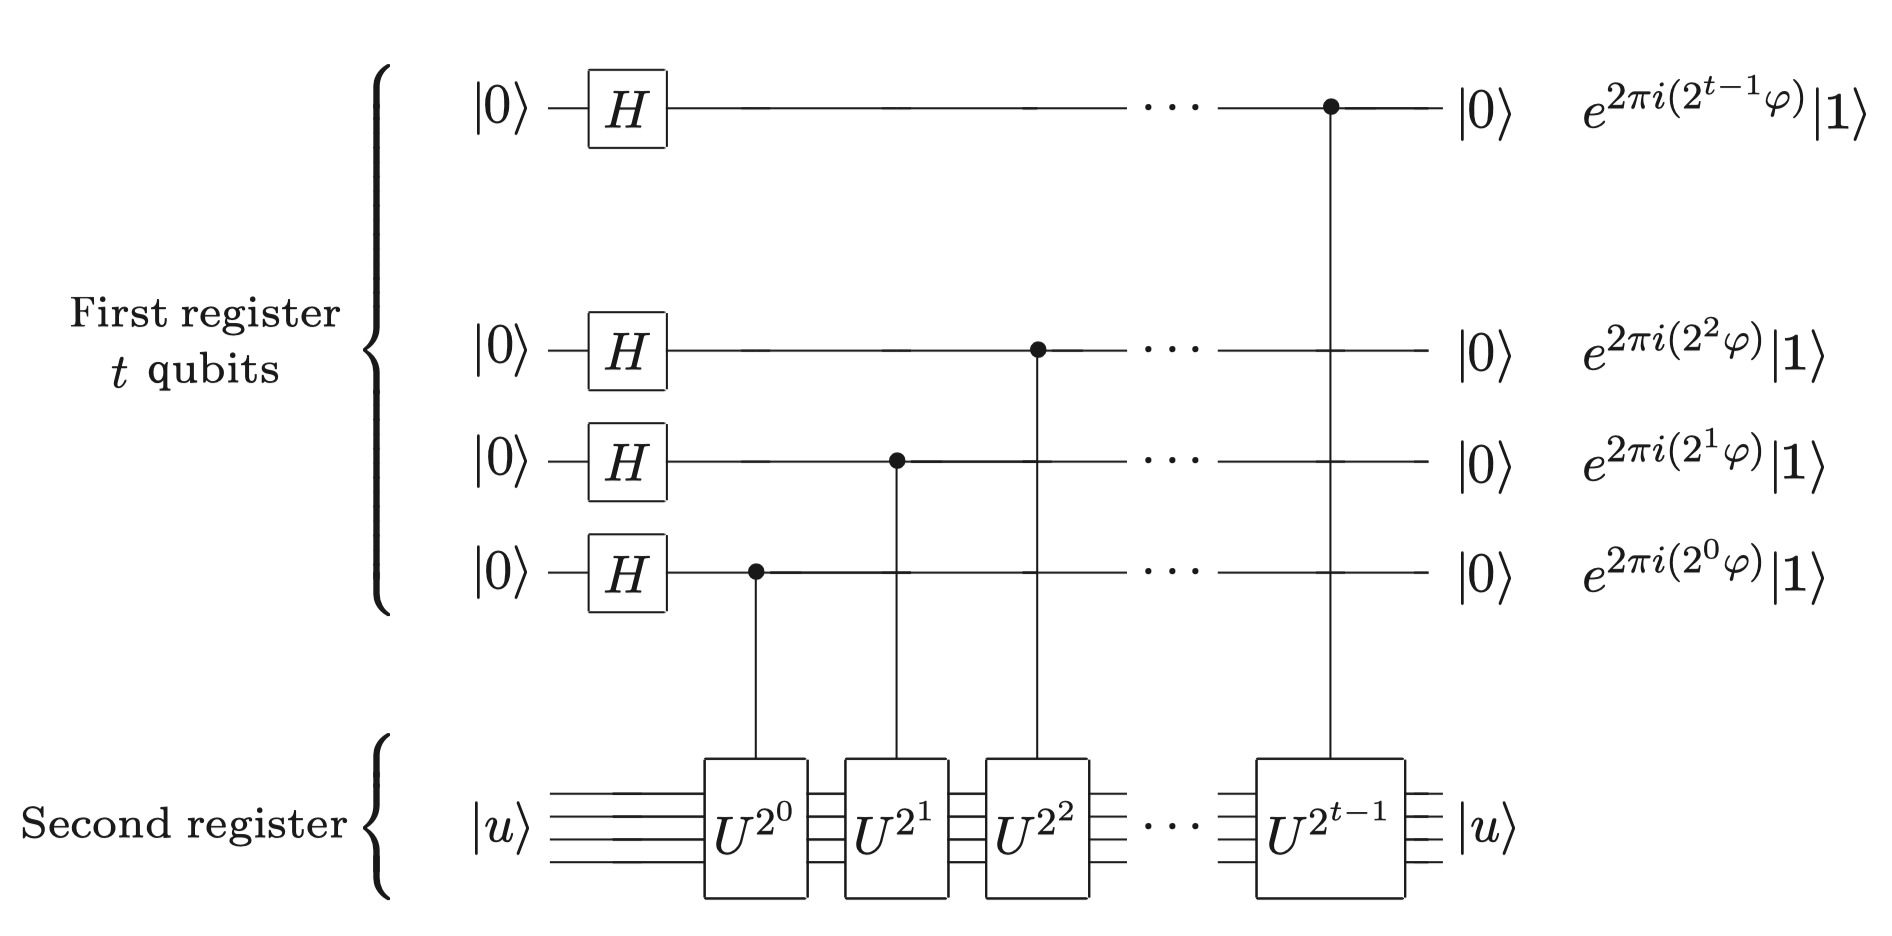


The state $|u\rangle$ must be the eigenstate or a superposition of eigenstate of the unitary $U$ for the algorithm to work properly. As stated, our unitary does the following transformation on the bottom register (multiplies by $a$ to the content of the register, mod N):

$$
U|y\rangle = |ay \mod N\rangle.
$$

It can be shown that the eigenvalue has the following form (you can see it by checking $U|u\rangle = \lambda |u\rangle$)

$$
|u_s\rangle = \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1}\exp{\Big[ \frac{-2\pi i sk}{r}\Big]}|x^k \mod N\rangle, ~~~ s=0,1,\cdots r-1.
$$

Preparing this state is not an easy task experimentally. We note that

$$ \frac{1}{\sqrt{r}} \sum_{k=0}^{r-1}|u_s\rangle = |1\rangle,$$  

which ($|1\rangle$) is a superposition of eigenstates and pretty easy to construct. Here is the required circuit.

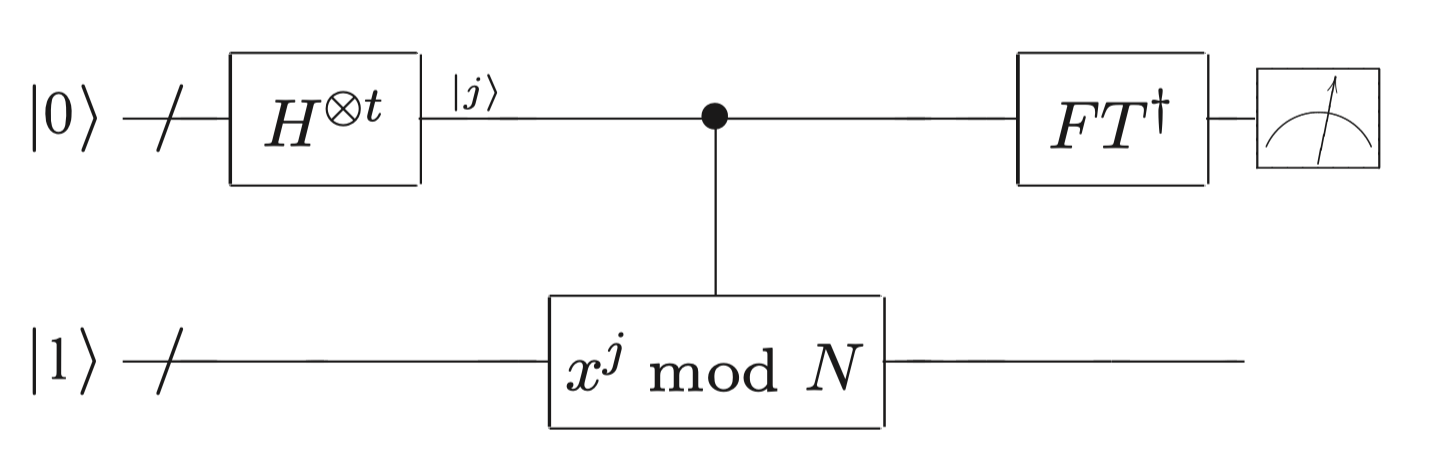




To implement the unitary $U$ that carries out transformation $|x\rangle|0\rangle \rightarrow |x\rangle|ax \text{ mod } N\rangle$, which uses the `controlled_mult_mod_N`, the article implements the following cicuit


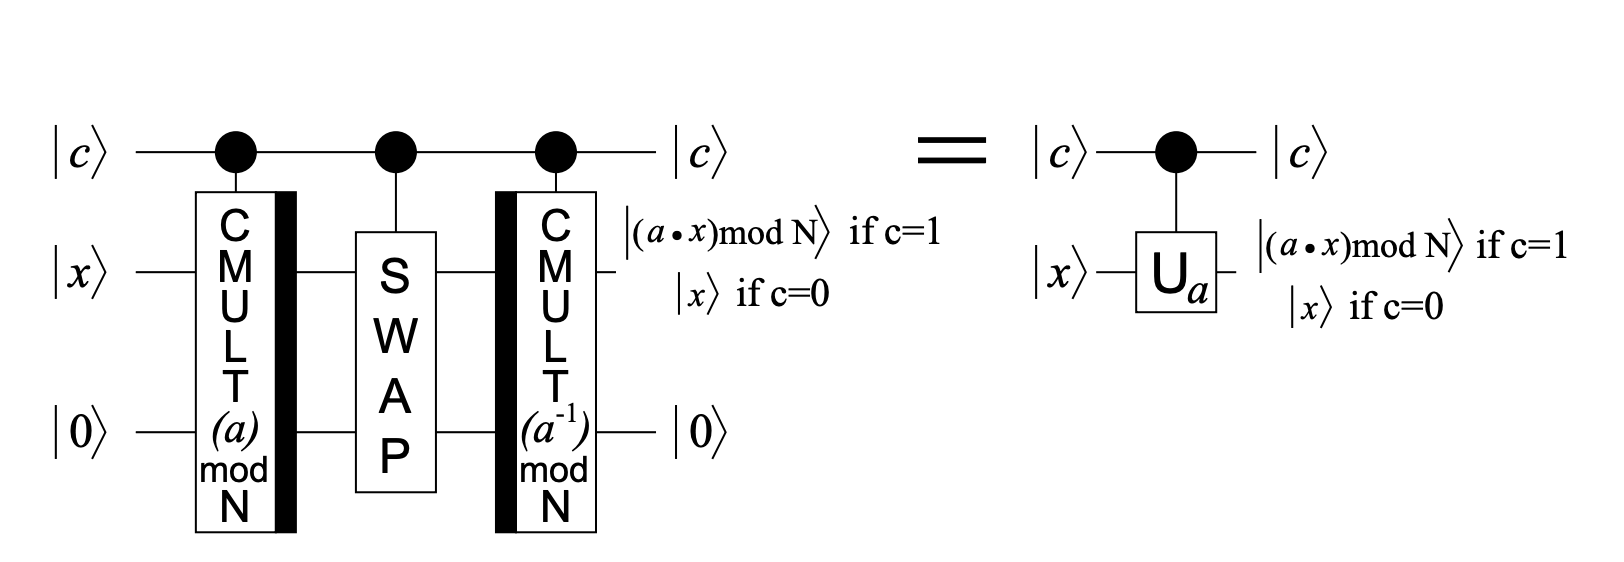

that uses another circuit, an adder in Fourier space (the function to be implemented below `add_in_fourier_space` as well as `controlled_controlled_add_in_fourier_space`)
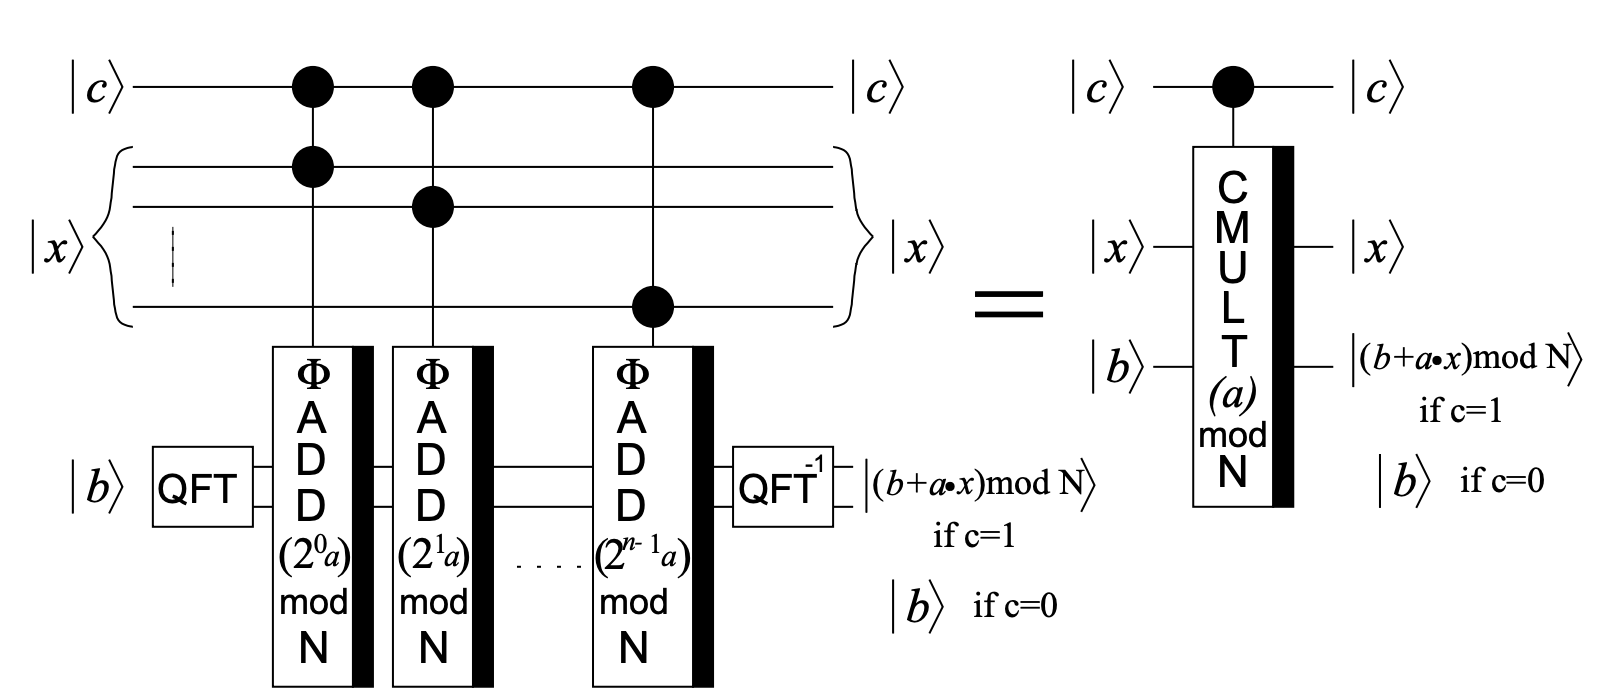





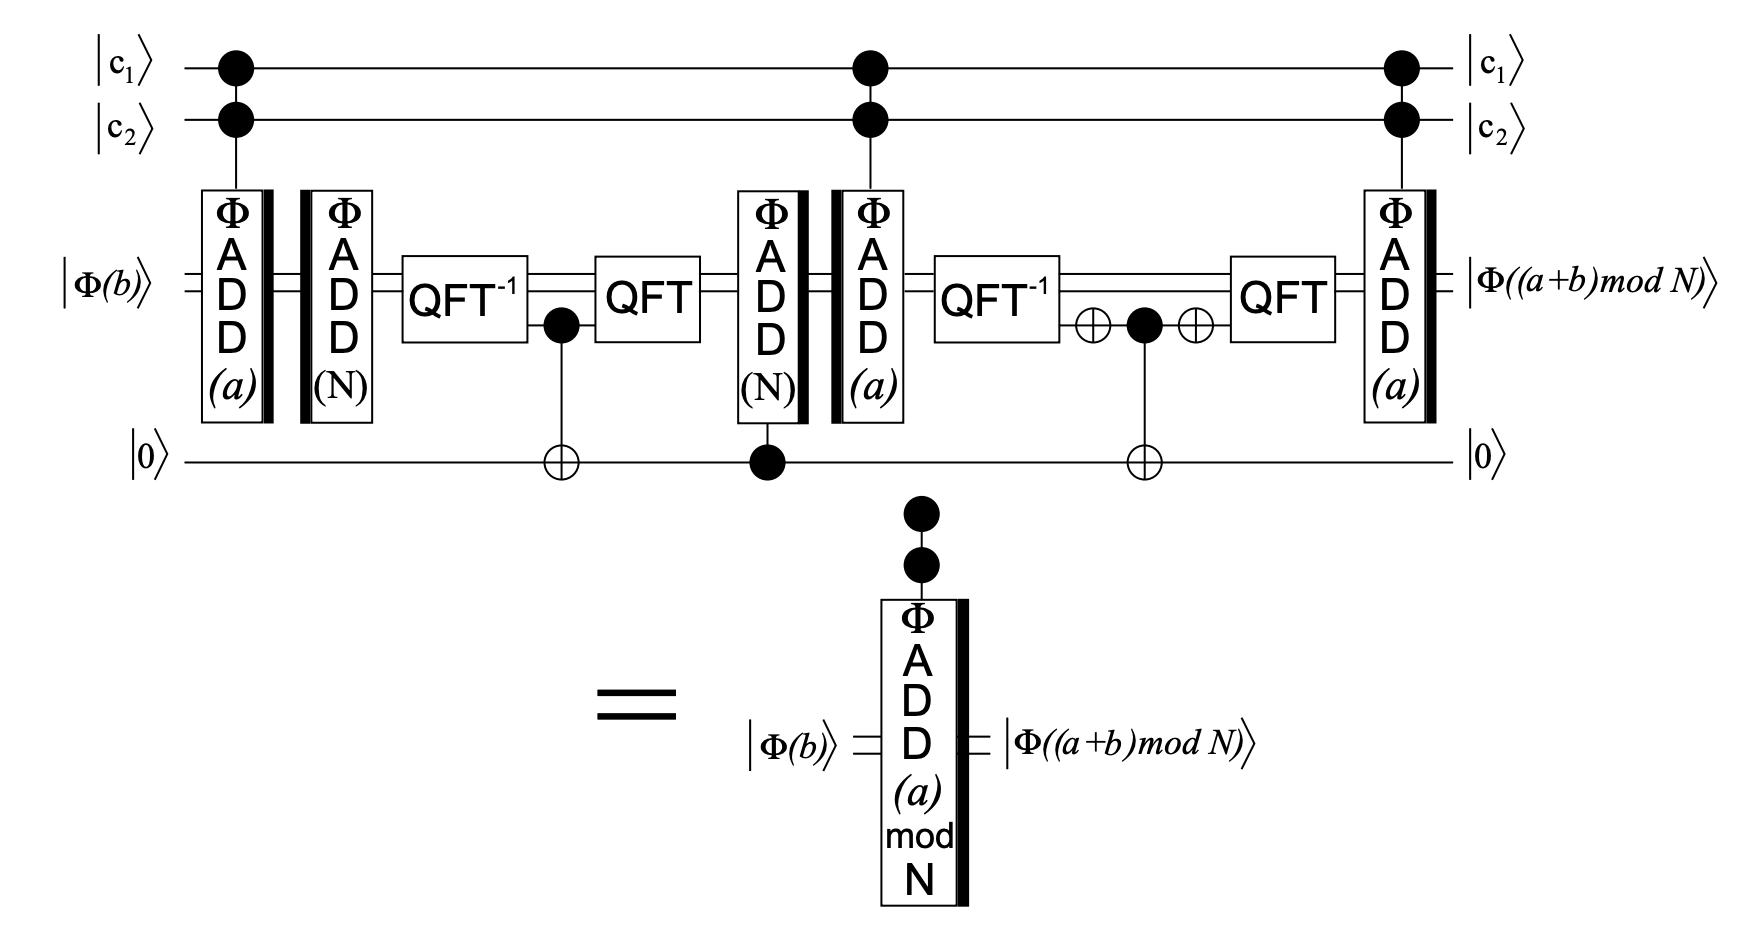


The addition in Fourier domain looks like the following



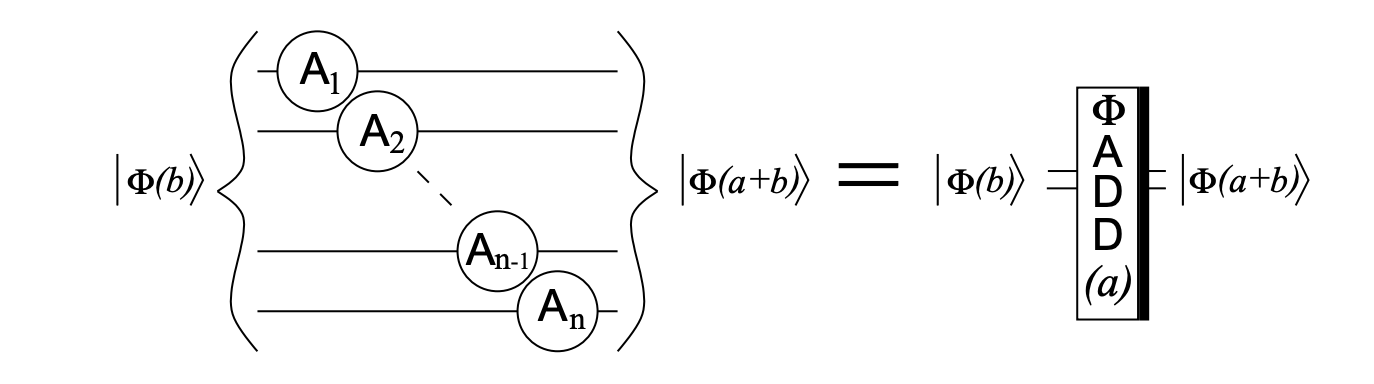


And if needed we can transform back by conjugating with quantum fourier transform (defined below)



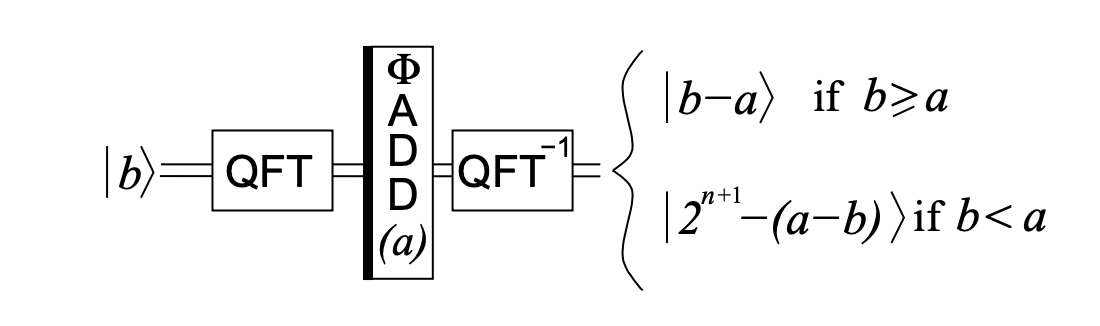

### Implement the above circuits from bottom to top

In [6]:
!pip install qiskit

In [7]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, IBMQ
from qiskit import BasicAer

import sys

import math
import random
import array
import fractions
import numpy as np

ImportError: cannot import name 'execute' from 'qiskit' (/usr/local/lib/python3.10/dist-packages/qiskit/__init__.py)

### Criate Circuit for Addition in Fourier domain

In [8]:
# first define a helper function to use below
def get_angles(a, N):
    """Function that calculates the array of angles
    to be used in the addition in Fourier Space"""

    s = bin(int(a))[2:].zfill(N)
    angles = np.zeros([N])
    for i in range(0, N):
        for j in range(i, N):
            if s[j] == '1':
                angles[N-i-1] += math.pow(2, -(j-i))
        angles[N-i-1] *= np.pi

    return angles


In [ ]:
def add_in_fourier_space(circuit, q, a, N, inv = False):
    """Creates the circuit that performs addition a in Fourier Space
    Can also be used for subtraction by setting
    the parameter inv to True"""

    angle = get_angles(a, N)
    for i in range(0, N):
        if inv == False:
            circuit.u1(angle[i], q[i])
        else:
            circuit.u1(-angle[i], q[i])

### Create Circuit for Controlled Controlled Addition in Fourier space

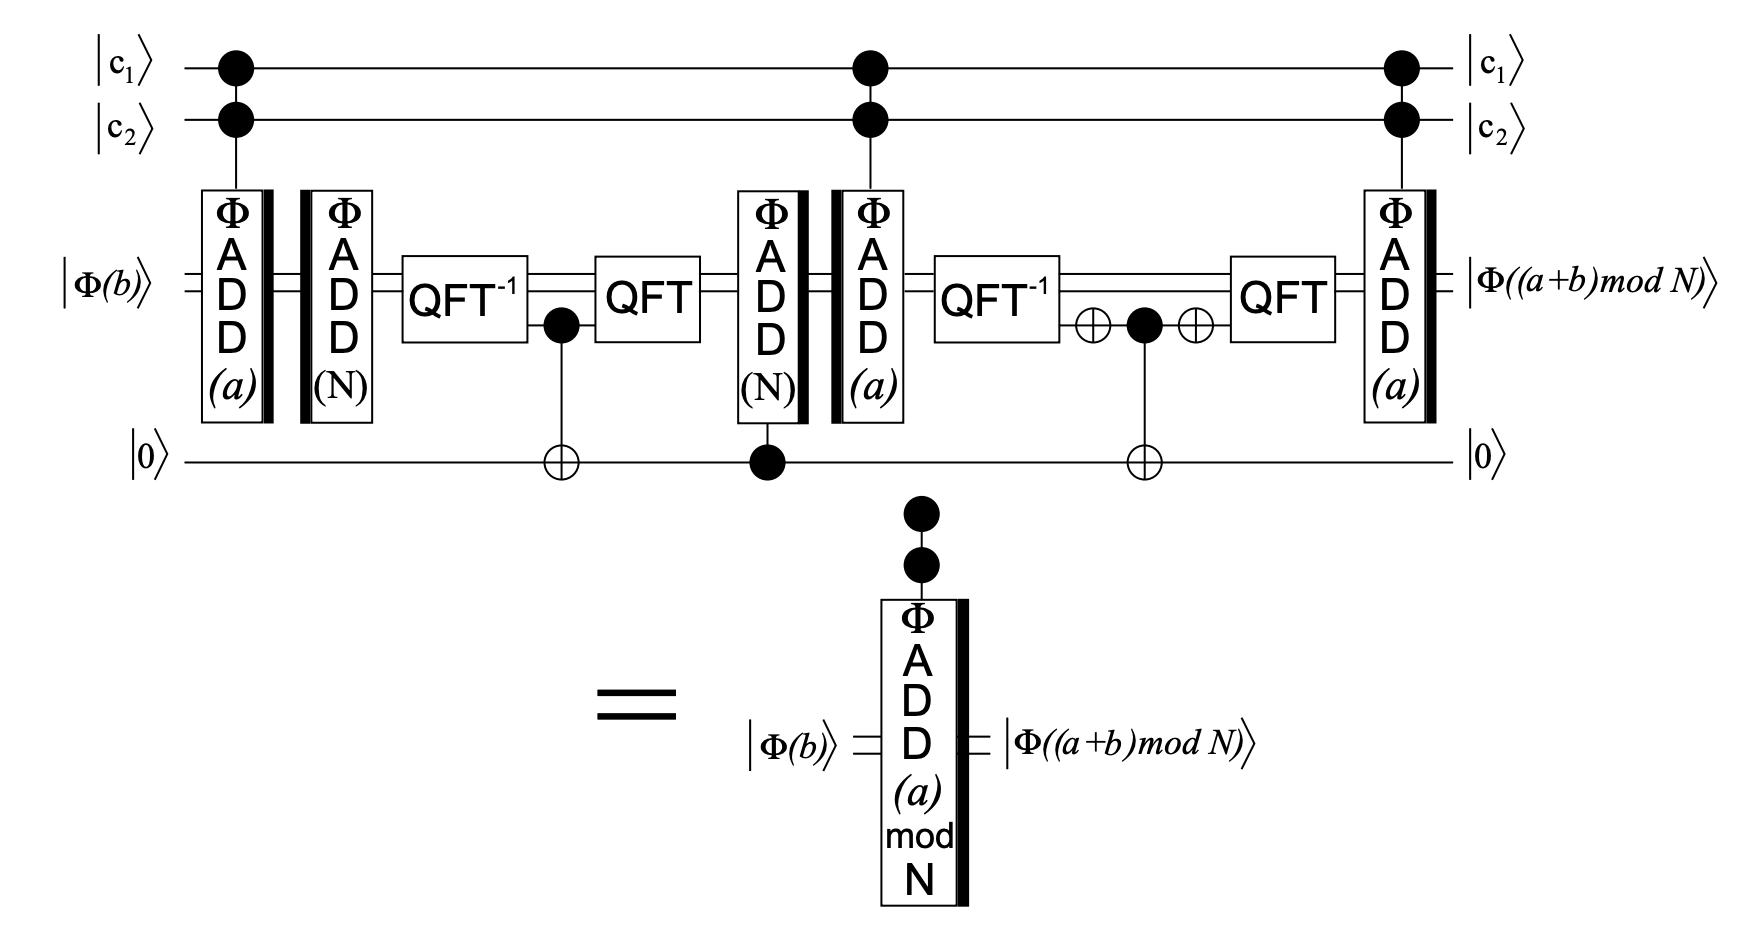


In order to implement the `Controlled Controlled Addition mod N`, we see that we need QFT, inverse QFT, `Controlled Addition` as well as `Controlled Controlled Addition`. Let's first implement the `Controlled Addition` and `Controlled Controlled Addition` gates and then cover the QFT theory and implementation of `Controlled Controlled Addition mod N`.

In [ ]:
def controlled_add_in_fourier_space(circuit, q, ctrl, a, n, inv=False):
    """Single controlled version of the add_in_fourier_space() circuit"""

    angle = get_angles(a, n)
    for i in range(n):
        if inv == False:
            circuit.cu1(angle[i], ctrl, q[i])
        else:
            circuit.cu1(-angle[i], ctrl, q[i])


In [ ]:
def ccphase(circuit, angle, ctrl1, ctrl2, tgt):
    """Creates a doubly controlled phase gate,
    a helper function for doubly controlled addition"""

    circuit.cu1(angle/2, ctrl1, tgt)
    circuit.cx(ctrl2, ctrl1)
    circuit.cu1(-angle/2, ctrl1, tgt)
    circuit.cx(ctrl2, ctrl1)
    circuit.cu1(angle/2, ctrl2, tgt)

In [ ]:
def controlled_controlled_add_in_fourier_space(circuit, q, ctrl1, ctrl2, a, n, inv=False):
    """Doubly controlled version of the add_in_fourier_space() circuit"""

    angle = get_angles(a, n)
    for i in range(n):
        if inv == False:
            ccphase(circuit, angle[i], ctrl1, ctrl2, q[i])
        else:
            ccphase(circuit, -angle[i], ctrl1, ctrl2, q[i])

Now let's get intuition on QFT and implement it. Then we will combine it with the above gate to implement the `Controlled Controlled Addition` circuit.

## Quantum Fourier Transform

The Quantum Fourier Transform is a quantum version of the classical [discrete time Fourier Transform](https://en.wikipedia.org/wiki/Discrete-time_Fourier_transform). The classical Fourier Transform takes a vector of numbers, $x$ -- often a [digital sampling of a signal](https://en.wikipedia.org/wiki/Sampling_(signal_processing)) to be analyzed -- and transforms it to a vector of numbers, $y$, in the frequency domain.

\begin{equation}
y_k \equiv \frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{i2\pi jk/N}
\end{equation}

Periodic behavior in the time domain is more easily identified in the transformed [frequency domain](https://en.wikipedia.org/wiki/Frequency_domain), which is why we do this. For example, a sine wave that oscillates in time with a specific frequency will transform to a large amplitude spike at plus or minus that frequency in the transform domain. Thus, it's easy to identify the location of the spikes and then read off the frequency directly. And if we know a signal's frequency, then we also know its period, since the frequency is $1/\text{period}$.\\
Now, the Quantum Fourier Transform is essentially the same transformation, which is why we'll use it here for period finding. It takes a state $|j\rangle$ and transforms it to a superposition state with specific phase factors.

\begin{equation}
|j\rangle \rightarrow \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}e^{i2\pi jk/N}|k\rangle
\end{equation}

If we start with a superposition state with coefficients $x_j$, the transformed result is also a superposition state with coefficients $y_k$, where the \textit{probability amplitudes $y_k$ are the classical discrete time Fourier Transform of the probability amplitudes $x_j$}.

\begin{equation}
\sum_{j=0}^{N-1}x_j|j\rangle \rightarrow \sum_{k=0}^{N-1}\frac{1}{\sqrt{N}}\sum_{j=0}^{N-1}x_je^{i2\pi jk/N}|k\rangle = \sum_{k=0}^{N-1}y_k|k\rangle
\end{equation}

And due to quantum parallelism and quantum interference, implementing the Quantum Fourier Transform is exponentially faster than implementing the classical fast Fourier Transform algorithm. That sounds great, but there's an important catch related to quantum measurement.
As you know, the measurement of a quantum state is probabilistic. Although the output of the Quantum Fourier Transform is a large superposition state with transformed probability amplitudes, we generally can't access those amplitudes. Our measurement projects out only a single state, and even if we identically prepare the system and measure it many times, we only learn about the magnitude squared of the corresponding coefficients. We lose the phase information. So we don't have access to the probability amplitudes in the quantum computer, and this is quite different from the classical Fourier Transform where the entire output vector of complex numbers can be directly read. Thus, the Quantum Fourier Transform is most useful in problems where there's a unique period or phase that can be found with high probability.


If we represent the ket $|j\rangle$ in its binary representation $|j_1\rangle\otimes |j_2\rangle\otimes\cdots \otimes |j_n\rangle$, then the $n$-qubit output state can be written as the product ofnsingle-qubit states (for the derivation, see chapter 5 of Nilsen $\&$ Chuang, Eqs (5.5)-(5.10))

$$
\left\vert j_{1}\right\rangle \otimes \left\vert j_{2}\right\rangle \otimes \nonumber...\otimes \left\vert  j_{n-1}\right\rangle  \otimes \left\vert j_{n}\right\rangle \rightarrow
\left( \frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{n}\right) \left\vert 1\right\rangle }{\sqrt{2}}\right) \otimes \left( \frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{n-1}j_{n}\right) \left\vert 1\right\rangle }{\sqrt{2}}\right) \otimes ...\otimes \left( \frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{2}...j_{n}\right) \left\vert 1\right\rangle }{\sqrt{2}}\right) \otimes \left( \frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{1}...j_{n}\right) \left\vert 1\right\rangle }{\sqrt{2}}\right).  
$$

The figure below shows a graphical representation of the Quantum Fourier Transform for an $n$-qubit system.
<img src="images/qft_transform.jpg">

The figure below shows the circuit implementation of the Quantum Fourier Transform in terms of multiple Hadamard gates and controlled gates.

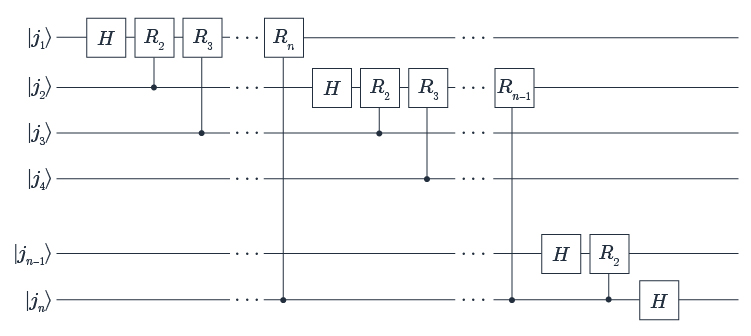

The phase rotation $R_k$ is defined as

$$R_k\lvert 0\rangle = \lvert 0\rangle,$$  

$$R_k\lvert 1\rangle = \displaystyle \exp \left(i\frac{2\pi }{2^{k}}\right) \left\vert 1\right\rangle .$$  

To return the qubit states to their original ordering, we need to apply **SWAP**-gates, which aregenerally used to exchange qubit states.

Let's analyze how the system evolves under this implementation.


A Hadamard gate is applied on the first qubit

$$\lvert j_1 \rangle \rightarrow \frac{\lvert 0 \rangle + \exp (2\pi i0.j_1)\lvert 1 \rangle }{\sqrt{2}},$$

and this puts the system in state

$$\frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{1}\right) \left\vert 1\right\rangle }{\sqrt {2}}\otimes \left\vert j_{2}\right\rangle \otimes \left\vert j_{3}\right\rangle \otimes ...\otimes \left\vert j_{n}\right\rangle .$$

 A controlled phase  $R_2$-gate is applied with the second qubit as control and the first as target,

$$\frac{\left\vert 0 \right \rangle + \exp \left(2\pi i0.j_1 j_2\right) \left\lvert 1 \right\rangle }{\sqrt{2}}\otimes \left\lvert j_2 \right\rangle \otimes \left\lvert j_3 \right \rangle \otimes ... \otimes \left\vert j_n \right\rangle .$$

A controlled phase $R_3$-gate is applied with the third qubit as control and the first as target,

$$\frac{\left\vert 0\right\rangle + \exp \left(2\pi i0.j_1 j_2 j_3 \right) \left \vert 1 \right \rangle}{\sqrt{2}} \otimes \left\vert j_2 \right \rangle \otimes \left\vert j_3 \right\rangle \otimes ... \otimes \left\vert j_n \right\rangle.$$

This continues until a controlled phase  $R_n$-gate is applied with the last qubit as control and the first as target, leaving the system in the state

$$\frac{\left\vert 0 \right \rangle + \exp \left(2\pi i0.j_1 j_2 j_3 ... j_n\right) \left\vert 1 \right\rangle}{\sqrt{2}}\otimes \left\vert j_2 \right\rangle \otimes \left\vert j_3 \right\rangle \otimes ... \otimes \left\vert j_n \right\rangle.$$

A Hadamard gate is applied on the second qubit,

$$\left (\frac{\left\vert0\right\rangle+\exp \left (2 \pi i0.j_1j_2j_3...j_n\right) \left\vert 1 \right\rangle}{\sqrt{2}}\right)\otimes \left(\frac{\left\vert 0 \right\rangle + \exp \left(2 \pi i0.j_2\right) \left\vert 1 \right\rangle}{\sqrt{2}}\right) \otimes \left\vert j_3 \right\rangle \otimes ... \otimes \left\vert j_n\right\rangle.$$

A controlled phase  $R_2$ -gate is applied with the third qubit as control and the second as target,

$$\left(\frac{\left\vert 0 \right\rangle + \exp \left (2 \pi i0.j_1 j_2 j_3 ... j_n\right) \left\vert 1 \right\rangle}{\sqrt{2}}\right) \otimes \left(\frac{\left\vert 0 \right\rangle + \exp \left(2\pi i0.j_2 j_3 \right) \left\vert 1 \right\rangle}{\sqrt{2}}\right) \otimes \left\vert j_3\right\rangle\otimes ... \otimes \left\vert j_n \right\rangle.$$

This continues until a controlled phase  $R_{n-1}$-gate is applied with the last qubit as control and the second as target, leaving the system in the state

$$\frac{\left\vert 0 \right\rangle + \exp \left(2\pi i0.j_1 j_2 j_3 ... j_n \right) \left\vert 1 \right\rangle}{\sqrt{2}}\otimes\frac{\left\vert 0\right\rangle + \exp \left(2 \pi i0.j_2 j_3 ... j_n\right) \left\vert 1 \right\rangle }{\sqrt{2}} \otimes \left\vert j_3 \right\rangle \otimes ... \otimes \left\vert j_n\right\rangle.$$

This same process is done on each qubit until the last qubit, on which you can only apply a Hadamard gate. This implementation transforms as



$$
\left\vert j_{1}\right\rangle \otimes \left\vert j_{2}\right\rangle \otimes ...\otimes \left\vert j_{n-1}\right\rangle \otimes \left\vert j_{n}\right\rangle \rightarrow \left( \frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{1}...j_{n}\right) \left\vert 1\right\rangle }{\sqrt{2}}\right) \otimes \left( \frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{2}...j_{n}\right) \left\vert 1\right\rangle }{\sqrt{2}}\right)
\otimes ... \otimes \left( \frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{n-1}j_{n}\right) \left\vert 1\right\rangle }{\sqrt{2}}\right)
\otimes \left( \frac{\left\vert 0\right\rangle +\exp \left( 2\pi i0.j_{n}\right) \left\vert 1\right\rangle }{\sqrt{2}}\right) .
$$

To return the qubit states to their original ordering, we need to apply swap-gates, which are generally usedto exchange qubit states.

### Implement QFT and Inverse QFT

In [9]:
def create_QFT(circuit, reg, n , with_swaps = False):
    """ Function to create QFT """

    # Apply the H gates and Cphases
    """ The Cphases with |angle| < threshold are not created because they do
    nothing. The threshold is put as being 0 so all CPhases are created,
    but the clause is there so if wanted just need to change the 0 of the
    if-clause to the desired value """
    i = n - 1
    while i >= 0:
        circuit.h(up_reg[i])
        j = i - 1
        while j >= 0:
            if (np.pi) / (pow(2, (i-j))) > 0:
                circuit.cu1((np.pi)/(pow(2, (i-j))), reg[i], reg[j]) # cu1(angle, ctrl, trgt)
                j = j - 1
        i = i - 1

    # If specified, apply the Swaps at the end
    if with_swaps == True:
        i=0
        while i < ((n-1) / 2):
            circuit.swap(reg[i], reg[n-1-i])
            i = i + 1


In [10]:
def create_inverse_QFT(circuit, reg, n, with_swaps=False):
    """ Function to create inverse QFT """

    # If specified, apply the Swaps at the beggining
    if with_swaps == True:
        i = 0
        while i < ((n-1)/2):
            circuit.swap(reg[i], reg[n-1-i])
            i = i + 1

    """ Apply the H gates and Cphases"""
    i=0
    while i < n:
        circuit.h(reg[i])
        if i != n-1:
            j = i + 1
            y = i
            while y>=0:
                 if (np.pi) / (pow(2, (j-y))) > 0:
                    circuit.cu1(-(np.pi) / (pow(2, (j-y))), reg[j], reg[y])
                    y = y - 1
        i = i + 1

### Going back to implementing the CC adder and the "mod N" version of it

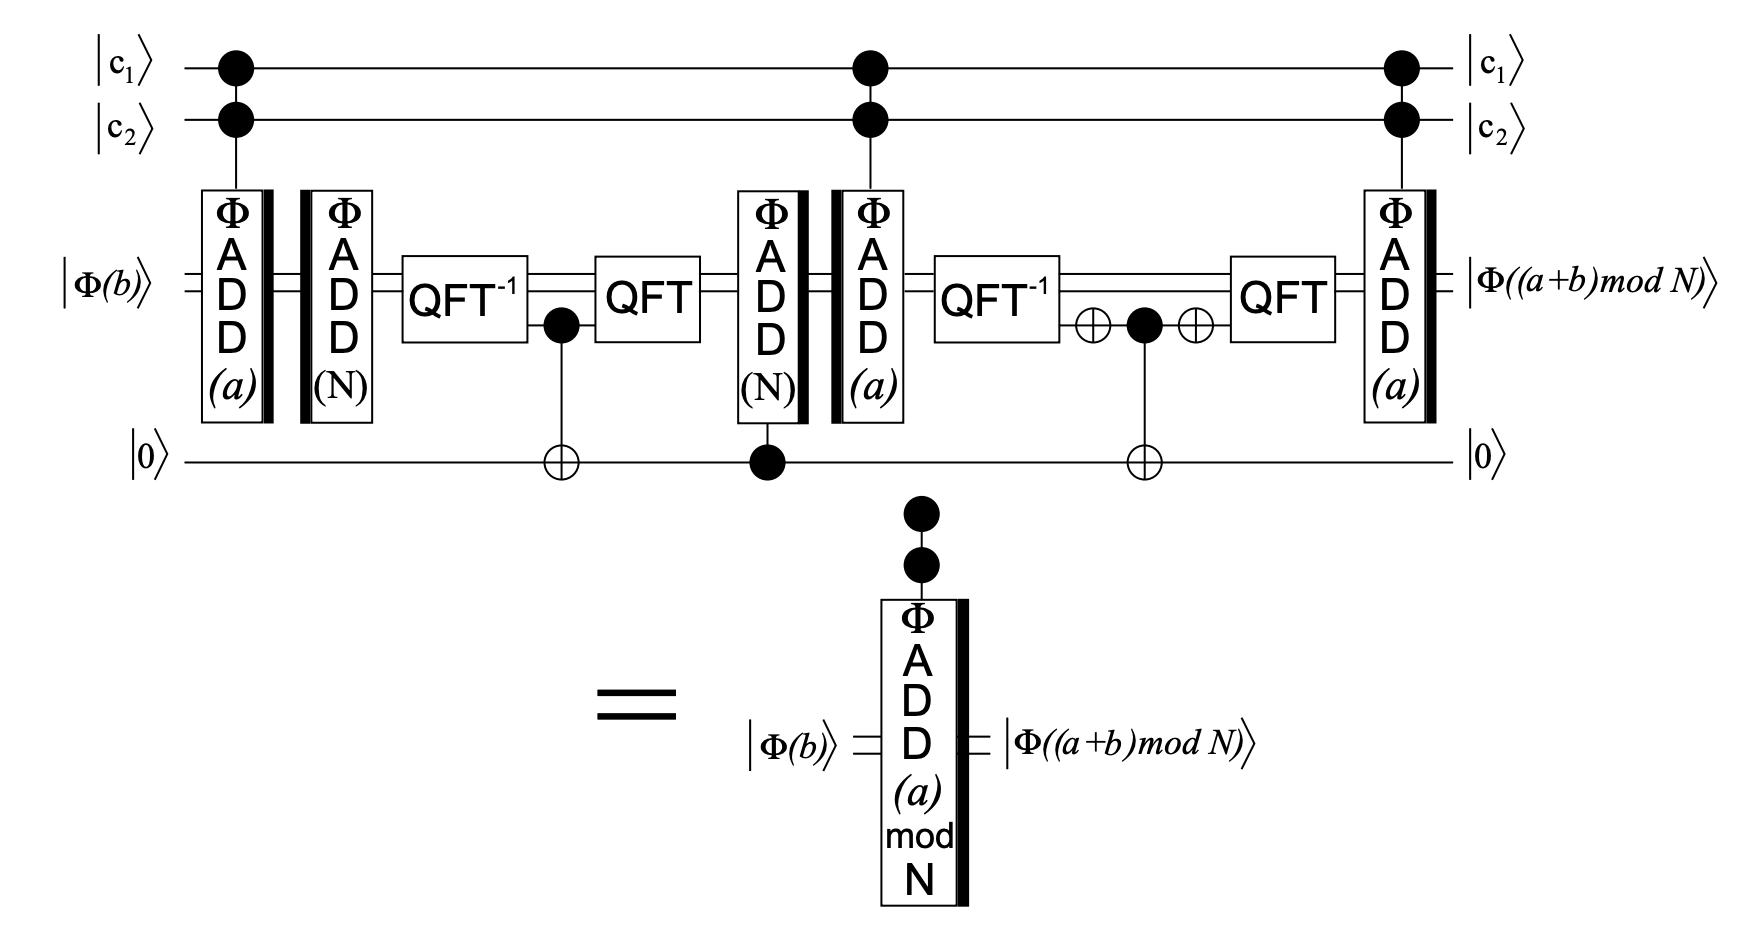

Let's implement the circuit and it's inverse.

In [11]:
def controlled_controlled_add_mod_N(circuit, q, ctrl1, ctrl2, aux, a, N, n):
    """Circuit that implements doubly controlled modular addition by a
    args: self explanatory from the picture"""

    controlled_controlled_add_in_fourier_space(circuit, q, ctrl1, ctrl2, a, n)
    add_in_fourier_space(circuit, q, N, n, inv=True)
    create_inverse_QFT(circuit, q, n)
    circuit.cx(q[n-1], aux)
    create_QFT(circuit, q, n)
    controlled_add_in_fourier_space(circuit, q, aux, N, n)

    controlled_controlled_add_in_fourier_space(circuit, q, ctrl1, ctrl2, a, n, inv=True)
    create_inverse_QFT(circuit, q, n)
    circuit.x(q[n-1])
    circuit.cx(q[n-1], aux)
    circuit.x(q[n-1])
    create_QFT(circuit, q, n)
    controlled_controlled_add_in_fourier_space(circuit, q, ctrl1, ctrl2, a, n)

def controlled_controlled_add_mod_N_inv(circuit, q, ctrl1, ctrl2, aux, a, N, n):
    """Circuit that implements the inverse of doubly controlled modular addition by a"""

    controlled_controlled_add_in_fourier_space(circuit, q, ctrl1, ctrl2, a, n, inv=True)
    create_inverse_QFT(circuit, q, n)
    circuit.x(q[n-1])
    circuit.cx(q[n-1], aux)
    circuit.x(q[n-1])
    create_QFT(circuit, q, n)
    controlled_controlled_add_in_fourier_space(circuit, q, ctrl1, ctrl2, a, n)

    controlled_add_in_fourier_space(circuit, q, aux, N, n, inv=True)
    create_inverse_QFT(circuit, q, n)
    circuit.cx(q[n-1], aux)
    create_QFT(circuit, q, n)
    add_in_fourier_space(circuit, q, N, n)
    controlled_controlled_add_in_fourier_space(circuit, q, ctrl1, ctrl2, a, n, inv=True)

### Implement the controlled multiplication mod N circuit

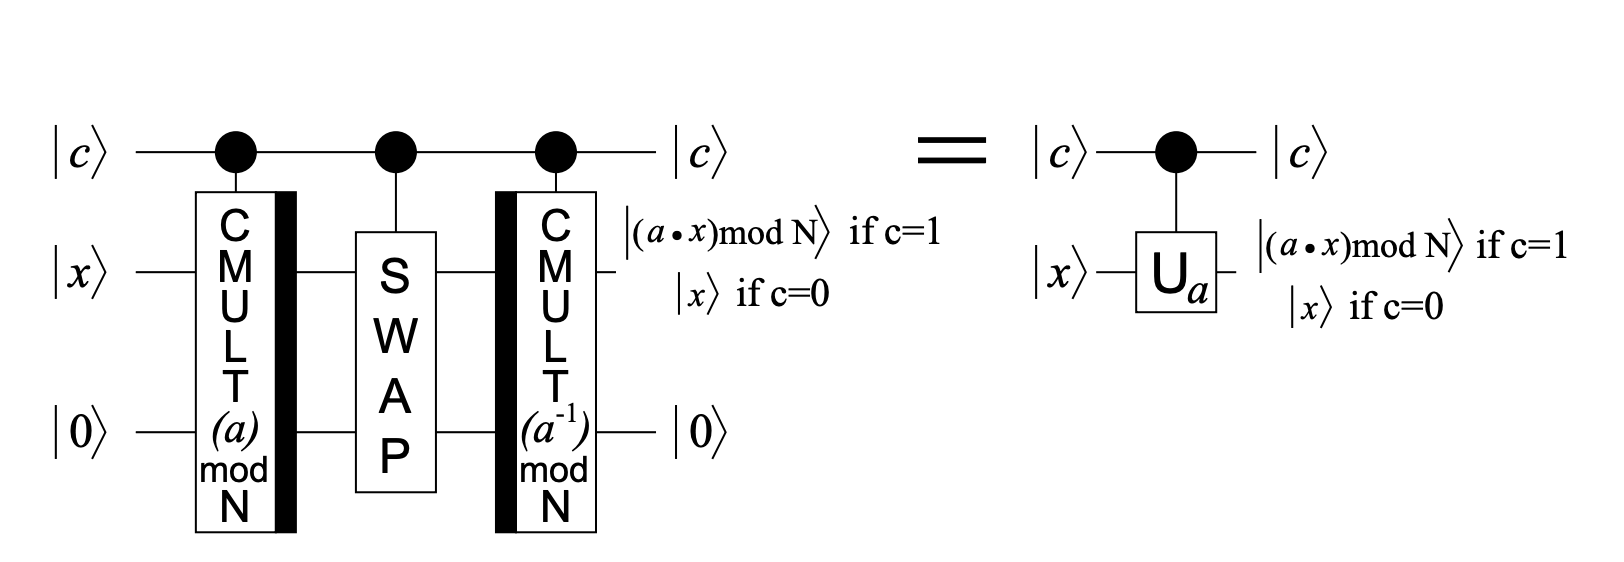


In [12]:
# helper functions
def euclid_gcd(a, b):
    if b == 0:
        return a
    return euclid_gcd(b, a % b)



def mod_inv(a, m):
    def extended_gcd(a, b):

        if b == 0:
            return a, 1, 0
        gcd, x_, y_ = extended_gcd(b, a % b)
        x = y_
        y = x_ - (a // b) * y_
        return gcd, x, y

    gcd, x, _ = extended_gcd(a, m)
    if gcd != 1:
        raise ValueError(f"{a} and {m} are not coprime.")
    return x % m


def controlled_mult_mod_N(circuit, ctrl, q, aux, a, N, n):
    """Circuit that implements single controlled modular multiplication by a
    args: self explanatory from the picture"""

    # CMULT(a) mod N
    create_QFT(circuit, aux, n+1)
    for i in range(0, n):
        controlled_controlled_add_mod_N(circuit, aux, q[i], ctrl, aux[n+1], (2**i)*a % N, N, n+1)
    create_inverse_QFT(circuit, aux, n+1, 0)

    for i in range(0, n):
        circuit.cswap(ctrl, q[i], aux[i])

    # CMULT(a^{-1}) mod N,
    # this is done to make sure circuit is reversible so that we can use the qubits further
    a_inv = mod_inv(a, N)
    create_QFT(circuit, aux, n+1, 0)
    i = n-1
    while i >= 0:
        controlled_controlled_add_mod_N_inv(circuit, aux, q[i], ctrl, aux[n+1], math.pow(2,i)*a_inv % N, N, n+1)
        i -= 1
    create_inverse_QFT(circuit, aux, n+1, 0)



### Going back to the original Shor's circuit and measurement of the Register 1

Now, returning to Shor's Algorithm, the Quantum Fourier Transform is applied here to the qubits in Register 1, and it imparts specific phase factors that are related to both $x$ and $z$.

\begin{eqnarray}
  \frac{1}{\sqrt{2^{2L}}}\sum_{x=0}^{2^{2L-1}}|x\rangle|a^x \mod N\rangle \xrightarrow {\substack{QFT}} &&\nonumber     \frac{1}{\sqrt{2^{2L}}} \sum_{z=0}^{2^{2L-1}}\sum_{x=0}^{2^{2L-1}} e^{i2\pi xz/2^{2L}}|z\rangle|a^x \mod N\rangle \\&&\nonumber =  \frac{1}{\sqrt{2^{2L}}}\sum_{z=0}^{2^{2L-1}}\sum_{x=0}^{2^{2L-1}} \omega^{xz}|z\rangle|a^x \mod N\rangle
\end{eqnarray}

That is, they're related to both the coefficients of the qubits on Register 1 and the modular exponentiation stored on Register 2. The phase sampling increment is represented here by $\omega$, and it's the phase

$$\frac{2\pi}{2^{2L}}.$$

Here we can see that increasing the number of qubits ($L$) will reduce the step size, and thus the error in estimating the actual period. Essentially, more qubits will more densely sample the phases that represent the period.
Lastly, we measure the qubits in Register 1. The projected state that results is a binary value of $z$, and its decimal value is

$$z_{\text{decimal}} = \text{integer} ~ \times 2^{2L}/r. $$  

Thus, it can be used to find the period $r$ using a [continued fraction expansion](https://en.wikipedia.org/wiki/Continued_fraction) of $z/2^{2L}$.


## Putting everyting together
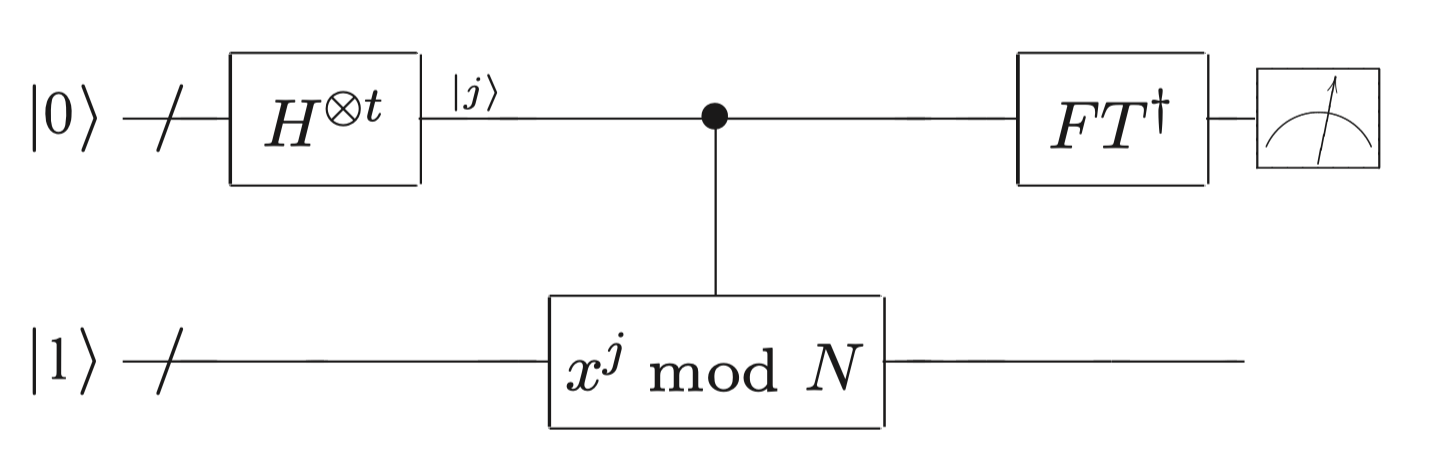


## Postprocessing the measurement and finding factors p and q of N=pq

##### Here are the steps of Shor's algorithm

    
1. randomly pick a number, $a$, that's smaller than $N$ and relatively prime. That is, their greatest common divisor--$\gcd (a,N)=1$.
    
2. We then use Shor's Algorithm to find the period of $a^x \mod N$. Shor's Algorithm, with classical post-processing, will efficiently give us the period $r$.
    Before proceeding, we need to do a couple checks.  
    $r$ must be an even number
    we need to ensure that $a^{r/2} + 1 \neq 0 \mod N$.   
    If we fail either of these tests, we need to go back to step 1 and pick another value of $a$.
    
    
3. We know that $$a^r = 1 \mod N,$$ as this is a property of modular exponentiation. We can rewrite this expression as $$a^r - 1 = k N$$ for an integer $k$.
    
4. Replace $N$ with the unknown prime factors $p$ and $q$, and we factor the left-hand side to yield  

    $$a^r-1 = kpq.$$
    $$(a^{r/2}+1)(a^{r/2}-1) = kpq$$
    
5. Finally solve for $p$ and $q$:  

    $$p=\gcd (a^{r/2}+1, N)$$
    $$q=\gcd (a^{r/2}-1, N)$$


In [13]:
import math
import random

# Choose N
N = 15

def euclid_gcd(a, b):
    while b != 0:
        a, b = b, a % b
    return a

def get_value_a(N):
    while True:
        a = random.randint(2, N - 1)
        if euclid_gcd(a, N) == 1:
            return a


# choose a
a = get_value_a(N)

# define number of qubits
n = math.ceil(math.log(N, 2))
print('Total number of qubits used: {0}\n'.format(4*n + 2))

Total number of qubits used: 18



In [16]:
!pip install qiskit

In [14]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 87.3 MB/s eta 0:00:00


In [6]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
from numpy import linalg as la
from qiskit_aer import AerSimulator

def controlled_mult_mod_N(circuit, ctrl, q, aux, a, N, n):
    create_QFT(circuit, aux, n + 1)
    for i in range(n):
        controlled_controlled_add_mod_N(circuit, aux, q[i], ctrl, aux[n + 1], (2**i) * a % N, N, n + 1)
    create_inverse_QFT(circuit, aux, n + 1, 0)

    for i in range(n):
        circuit.cswap(ctrl, q[i], aux[i])

    a_inv = mod_inv(a, N)
    create_QFT(circuit, aux, n + 1, 0)

    for i in range(n - 1, -1, -1):
        controlled_controlled_add_mod_N_inv(circuit, aux, q[i], ctrl, aux[n + 1], (2**i) * a_inv % N, N, n + 1)

    create_inverse_QFT(circuit, aux, n + 1, 0)


# auxilliary quantum register used in addition and multiplication
aux = QuantumRegister(n + 2)

# quantum register where the sequential QFT is performed
up_reg = QuantumRegister(2 * n)

# quantum register where the multiplications are made
down_reg = QuantumRegister(n)

# classical register where the measured values of the QFT are stored
classic_reg = ClassicalRegister(2 * n)

# Create Quantum Circuit!
circuit = QuantumCircuit(down_reg , up_reg , aux, classic_reg)

# Initialize down register to |1> (see pic)
# and create maximal superposition in top register
circuit.h(up_reg)
circuit.x(down_reg[0])

# Apply the multiplication gates in order to create the exponentiation
for i in range(0, 2*n):
    controlled_mult_mod_N(circuit, up_reg[i], down_reg, aux, int(pow(a, pow(2, i))), N, n)

# Apply inverse QFT
create_inverse_QFT(circuit, up_reg, 2*n ,1)

# Measure the top qubits, to get value C
circuit.measure(up_reg, classic_reg)

ModuleNotFoundError: No module named 'qiskit'

In [7]:
def continued_fractions(C, K):
    """
    implements the cont frac algo
    C = a_0 + 1/(a_1 + 1/(a_2 + 1/(a_3 + .../(a_{K-1} + 1/a_K))))
    returns the list of [a_0, a_1, ..., a_K]
    """
    a = []
    for _ in range(K):
        a0 = int(C)
        a.append(a0)
        C = 1 / (C - a0)
        if C == 0:
            break
    return a

    return a


def convergents(a):
    """
    Finds convergents from coefficients
    param a: list, output of function continued_fractions(C, K)
    """
    print('a=: ', a)
    z = []
    r = []

    # set the first two elements: z0 = a0, z1=a1a0 + 1, r0=1, r1=a1
    z.append(a[0])
    r.append(1)
    z.append(a[1] * a[0] + 1)
    r.append(a[1])

    for i in range(2, len(a)):
        z.append(a[i] * z[i-1] + z[i-2])
        r.append(a[i] * r[i-1] + r[i-2])
    return z, r



def check_and_return_period(a, N, K=10):
    C = math.log(N, 2)
    c_f = continued_fractions(C, K)
    z, r = convergents(c_f)

    for rk in r:
        if pow(a, rk, N) == 1:
            return rk
    return None


def find_rk(N, a, K):
    c_f = continued_fractions(math.log(N, 2), K)
    _, r = convergents(c_f)

    for rk in r:
        if pow(a, rk, N) == 1:
            return rk
    return None


def find_factors(a, N, r):
    if r is None or r % 2 != 0:
        return None

    x = pow(a, r // 2, N)
    p = math.gcd(x - 1, N)
    q = math.gcd(x + 1, N)

    if p * q == N:
        return p, q
    else:
        return None





### Run everyting and find factors

In [ ]:
""" Simulate the created Quantum Circuit """
# to run locally, use backend=BasicAer.get_backend('qasm_simulator') in execute() function
simulation = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=number_shots)


# Get the results of the simulation in proper structure
sim_result=simulation.result()
counts_result = sim_result.get_counts(circuit)


# Get the C value from the final state qubits
output_desired = list(sim_result.get_counts().keys())[i]
print('output_desired=: ', output_desired)

C  = int(output_desired, 2)
print('C=: ', C)

result = (int(list(sim_result.get_counts().values())[i]))

print("------> Analysing result {0}. \
This result happened in {1:.4f} % of all cases\n".format(output_desired, result))

# Print the final C value to user
print('In decimal, C value for this result is: {0}\n'.format(C))

# Get the period using the value obtained
period = check_and_return_period(C, 10, N)
print('period is : ', period)


# Get the factors using the period r
factors = find_factors(period)
print('the factors are : ', factors)